# PS Parallel Programming / Sheet 02
# Fabio Valentini / MN 01018782

## Exercise 1: The Mandelbrot Set

→ `./mandelbrot/mandelbrot.c`

![](./mandelbrot.png)

### Local Performance measurements

In [1]:
# initial setup

import subprocess
import time

from IPython.display import HTML, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse

%matplotlib inline
set_matplotlib_formats('svg')

SAMPLE_SIZE = 10

In [2]:
parser = parse.Parser("time: {time:.5f} seconds")

sequential = []
sequential_o2 = []
sequential_o3 = []

# run sequential mandelbrot implementation, SAMPLE_SIZE times
for i in range(SAMPLE_SIZE):
    ret = subprocess.run(["./mandelbrot/mandelbrot"], stdout=subprocess.PIPE)
    sequential.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./mandelbrot/mandelbrot-O2"], stdout=subprocess.PIPE)
    sequential_o2.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./mandelbrot/mandelbrot-O3"], stdout=subprocess.PIPE)
    sequential_o3.append(parser.parse(ret.stdout.decode())["time"])

Performance is very stable when running the algorithm multiple times (visualized by the very short boxes in the box plot). Also, enabling `-O3` compiler optimizations does not further improve performance compared to using `-O2`.

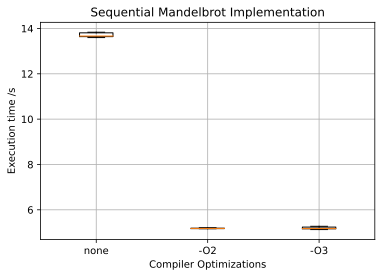

In [3]:
plt.boxplot([sequential, sequential_o2, sequential_o3], labels = ["none", "-O2", "-O3"])

plt.title("Sequential Mandelbrot Implementation")
plt.xlabel("Compiler Optimizations")
plt.ylabel("Execution time /s")

plt.grid()
plt.show()

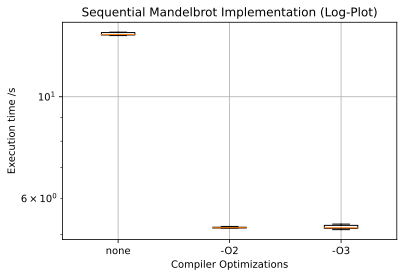

In [4]:
plt.boxplot([sequential, sequential_o2, sequential_o3], labels = ["none", "-O2", "-O3"])

plt.title("Sequential Mandelbrot Implementation (Log-Plot)")
plt.xlabel("Compiler Optimizations")
plt.ylabel("Execution time /s")

plt.yscale("log")
plt.grid()
plt.show()

In [5]:
data = np.array([sequential, sequential_o2, sequential_o3]).T

df = pd.DataFrame(data, columns=["none /s", "-O2 /s", "-O3 /s"])

HTML(df.to_html(index=False))

none /s,-O2 /s,-O3 /s
13.67979,5.16741,5.16163
13.65106,5.21019,5.18339
13.83582,5.16941,5.15994
13.65765,5.18413,5.26252
13.74787,5.17538,5.20125
13.59989,5.19954,5.15946
13.83578,5.16656,5.27161
13.82901,5.19217,5.12801
13.62625,5.17461,5.16370
13.63853,5.18096,5.25081


Additionally, a very simple parallel variant was implemented with OpenMP, parallelizing the "outer loop", i. e. computing lines of pixels in parallel.

→ `./mandelbrot_omp.c`

In [6]:
THREADS = 16

threads = [*range(1, THREADS+1)]

parallel = []
parallel_o2 = []
parallel_o3 = []

# run sequential mandelbrot implementation, for 1-16 threads
for p in threads:
    ret = subprocess.run(["./mandelbrot/mandelbrot-omp"], env={"OMP_NUM_THREADS": str(p)}, stdout=subprocess.PIPE)
    parallel.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./mandelbrot/mandelbrot-omp-O2"], env={"OMP_NUM_THREADS": str(p)}, stdout=subprocess.PIPE)
    parallel_o2.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./mandelbrot/mandelbrot-omp-O3"], env={"OMP_NUM_THREADS": str(p)}, stdout=subprocess.PIPE)
    parallel_o3.append(parser.parse(ret.stdout.decode())["time"])


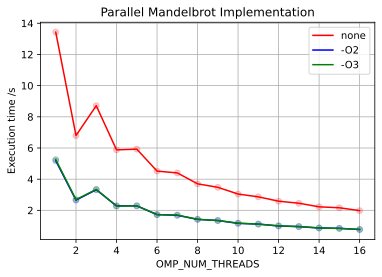

In [7]:
plt.plot(threads, parallel, "ro", alpha=0.2)
plt.plot(threads, parallel_o2, "bo", alpha=0.2)
plt.plot(threads, parallel_o3, "go", alpha=0.2)

plt.plot(threads, parallel, "r-", label="none")
plt.plot(threads, parallel_o2, "b-", label="-O2")
plt.plot(threads, parallel_o3, "g-", label="-O3")

plt.title("Parallel Mandelbrot Implementation")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

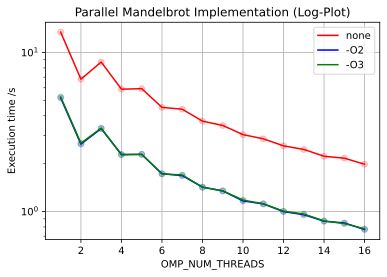

In [8]:
plt.plot(threads, parallel, "ro", alpha=0.2)
plt.plot(threads, parallel_o2, "bo", alpha=0.2)
plt.plot(threads, parallel_o3, "go", alpha=0.2)

plt.plot(threads, parallel, "r-", label="none")
plt.plot(threads, parallel_o2, "b-", label="-O2")
plt.plot(threads, parallel_o3, "g-", label="-O3")

plt.title("Parallel Mandelbrot Implementation (Log-Plot)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

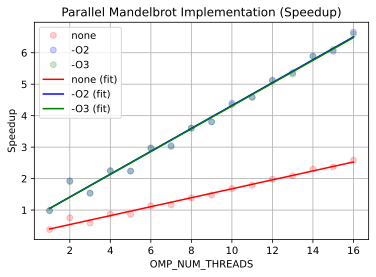

In [9]:
fastest_sequential = np.array(sequential_o3).min()

# calculate speedups
speedup = fastest_sequential / parallel
speedup_o2 = fastest_sequential / parallel_o2
speedup_o3 = fastest_sequential / parallel_o3

plt.plot(threads, speedup, "ro", alpha=0.2, label="none")
plt.plot(threads, speedup_o2, "bo", alpha=0.2, label="-O2")
plt.plot(threads, speedup_o3, "go", alpha=0.2, label="-O3")

# linear regression
coef = np.polyfit(threads, speedup, 1)
coef_o2 = np.polyfit(threads, speedup_o2, 1)
coef_o3 = np.polyfit(threads, speedup_o3, 1)

plt.plot(threads, np.poly1d(coef)(threads), "r-", label="none (fit)")
plt.plot(threads, np.poly1d(coef_o2)(threads), "b-", label="-O2 (fit)")
plt.plot(threads, np.poly1d(coef_o3)(threads), "g-", label="-O3 (fit)")

plt.title("Parallel Mandelbrot Implementation (Speedup)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

The speedup for more available threads is almost exactly linear with the number of available threads (curiously, even numbers of threads seem to yield slightly better results than odd numbers across the board).

In [10]:
data = np.array([threads, parallel, speedup, parallel_o2, speedup_o2, parallel_o3, speedup_o3]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "OMP_NUM_THREADS",
        "none /s",
        "speedup",
        "-O2 /s",
        "speedup",
        "-O3 /s",
        "speedup",
    ]
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,none /s,speedup,-O2 /s,speedup,-O3 /s,speedup
1.0,13.42947,0.381848,5.18458,0.989089,5.25979,0.974946
2.0,6.79835,0.754302,2.65544,1.931134,2.69080,1.905757
3.0,8.71260,0.588574,3.32192,1.543689,3.34758,1.531856
4.0,5.88045,0.872044,2.28617,2.243057,2.27233,2.256719
5.0,5.92597,0.865345,2.28782,2.241439,2.28983,2.239472
6.0,4.51847,1.134900,1.72940,2.965196,1.72335,2.975606
7.0,4.40066,1.165282,1.68217,3.048449,1.69893,3.018376
8.0,3.70155,1.385368,1.42393,3.601308,1.42138,3.607769
9.0,3.47693,1.474867,1.34731,3.806110,1.34932,3.800440
10.0,3.04541,1.683849,1.16619,4.397234,1.17999,4.345808


### LCC2 Performance measurements

→ `./mandelbrot/sheet_02_1.job.sh`  
→ `./mandelbrot/sheet_02_1.dat`

In [11]:
lcc2_sequential = [
    19.60451,
    19.60061,
    19.60024,
    19.59871,
    19.60029,
    19.59916,
    19.59979,
    19.59934,
    19.61136,
    19.59978,
]

lcc2_sequential_o2 = [
    12.81434,
    12.81324,
    12.81428,
    12.81303,
    12.81404,
    12.82304,
    12.81465,
    12.81306,
    12.81446,
    12.81339,
]

lcc2_sequential_o3 = [
    12.81409,
    12.81332,
    12.82705,
    12.81326,
    12.81373,
    12.81351,
    12.81366,
    12.81373,
    12.81353,
    12.81361,
]

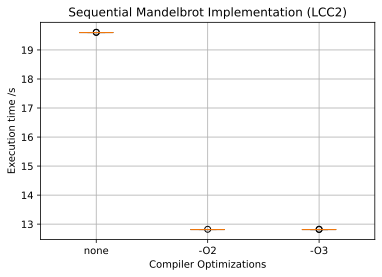

In [12]:
plt.boxplot([lcc2_sequential, lcc2_sequential_o2, lcc2_sequential_o3], labels = ["none", "-O2", "-O3"])

plt.title("Sequential Mandelbrot Implementation (LCC2)")
plt.xlabel("Compiler Optimizations")
plt.ylabel("Execution time /s")

plt.grid()
plt.show()

In [13]:
data = np.array([lcc2_sequential, lcc2_sequential_o2, lcc2_sequential_o3]).T

df = pd.DataFrame(data, columns=["none", "-O2", "-O3"])

HTML(df.to_html(index=False))

none,-O2,-O3
19.60451,12.81434,12.81409
19.60061,12.81324,12.81332
19.60024,12.81428,12.82705
19.59871,12.81303,12.81326
19.60029,12.81404,12.81373
19.59916,12.82304,12.81351
19.59979,12.81465,12.81366
19.59934,12.81306,12.81373
19.61136,12.81446,12.81353
19.59978,12.81339,12.81361


In [14]:
# best sequential time on LCC2
best = min(lcc2_sequential + lcc2_sequential_o2 + lcc2_sequential_o3)
print(f"Best sequential execution time on LCC2: {best} s")

Best sequential execution time on LCC2: 12.81303 s


Similar to executing the sequential program locally, the `-O2` and `-O3` compiler optimization levels significantly improve performance (even if not by as much as on my local system), with no meaningful difference between `-O2` and `-O3`.

## Exercise 2: Hadamard Product

→ `./hadamard/hadamard_stupid.c`  
→ `./hadamard/hadamard_smart.c`

Algorithm 1:

```c
for (size_t i = 0; i < n; ++i) {
    for (size_t j = 0; j < n; ++j) {
        c[i][j] = a[i][j] * b[i][j];
    }
}
```

Algorithm 2:

```c
for (size_t j = 0; j < n; ++j) {
    for (size_t i = 0; i < n; ++i) {
        c[i][j] = a[i][j] * b[i][j];
    }
}
```

### Estimate cache read misses

Assumptions:

- elements of \\( n * n \\) matrix are of type `uint32_t` (4 bytes)
- memory for matrix is contiguous
- size of matrix is much too big to fit into a cache line (\\( n >> s \\))
- 8-way-associative cache (but: internal cache implementation not relevant here)

Algorithm 1:

- high data locality, reads elements from `a` and `b` completely sequentially
- number of cache lines to fit **one** entire matrix is \\( \lceil \frac{4 \cdot n^2}{s} \rceil \\)
- cache misses per cache line: \\( 1 \\)
- cache hits per cache line: (\\( \lceil\frac{s}{4}\rceil - 1 \\))

\\[ f_1 (n, s) = \left \lceil \frac{8 \cdot n^2}{s} \right \rceil \\]

Algorithm 2:

- no data locality
- elements from `a` and `b` are read such that there are only cache misses (for \\( n >> s \\))
- number of read accesses in `a` and `b` are \\(2 \cdot n^2\\)

\\[ f_2 (n, s) = 2 \cdot n^2 \\]

## Measured cache read misses on LCC2

→ `./hadamard/sheet_02_2.job.sh`  
→ `./hadamard/sheet_02_2.dat`

Algorithm 1:

- \\( f_1 \\) for `n = 1000` and `s = 64 bytes` estimates 125,000 cache read misses
- `cachegrind` estimates 127,579 D1 cache read misses, matching the theoretical estimate
- `perf` shows only 3,240 "real" cache misses (the "smart" algorithm probably benefits from cache prefetching)

Algorithm 2:

- \\( f_2 \\) for `n = 1000` and `s = 64` bytes estimates 2,000,000 cache read misses
- `cachegrind` estimates 2,002,577 D1 cache read misses, matching the theoretical estimate
- `perf` shows only 81,086 "real" cache misses (maybe the CPU cache is big enough to keep *some* values in cache?)

## Exercise 3: Monte-Carlo-Pi

→ `./montecarlo/mcpi_seq.c`  
→ `./montecarlo/mcpi_par.c`

### Notes on the implementation

The `rand` function from `stdlib.h` is not re-entrant and not necessarily thread-safe in all standard library implementations. For threaded applications that do not care about cryptographically "good" random numbers, the documentation recommends to use the re-entrant `rand_r` function instead. To make sure the the performance between the sequential and the parallel implementations stays comparable, the `rand_r` function is used in both cases.

### Local Performance measurements

#### Sequential implementation

In [15]:
parser = parse.Parser("Iterations: {iterations}; pi: {pi}; time: {time:.5f}")

iterations = [
    100_000, 200_000, 500_000,
    1_000_000, 2_000_000, 5_000_000,
    10_000_000, 20_000_000, 50_000_000,
    100_000_000, 200_000_000, 500_000_000,
    1_000_000_000,
]

sequential = []
sequential_o2 = []
sequential_o3 = []

# run sequential monte-carlo-pi implementation with different number of iterations
for i in iterations:
    ret = subprocess.run(["./montecarlo/mcpi_seq", str(i)], stdout=subprocess.PIPE)
    sequential.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./montecarlo/mcpi_seq-O2", str(i)], stdout=subprocess.PIPE)
    sequential_o2.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./montecarlo/mcpi_seq-O3", str(i)], stdout=subprocess.PIPE)
    sequential_o3.append(parser.parse(ret.stdout.decode())["time"])

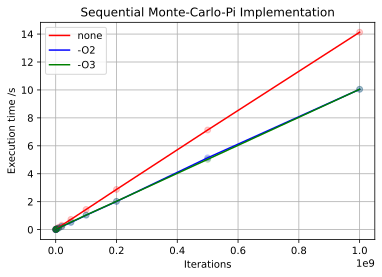

In [16]:
plt.plot(iterations, sequential, "ro", alpha=0.2)
plt.plot(iterations, sequential_o2, "bo", alpha=0.2)
plt.plot(iterations, sequential_o3, "go", alpha=0.2)

plt.plot(iterations, sequential, "r-", label="none")
plt.plot(iterations, sequential_o2, "b-", label="-O2")
plt.plot(iterations, sequential_o3, "g-", label="-O3")

plt.title("Sequential Monte-Carlo-Pi Implementation")
plt.xlabel("Iterations")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

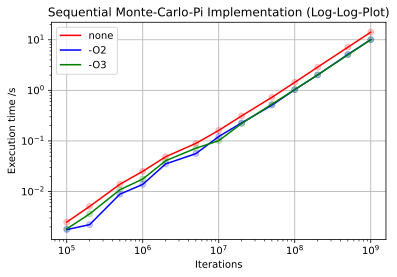

In [17]:
plt.plot(iterations, sequential, "ro", alpha=0.2)
plt.plot(iterations, sequential_o2, "bo", alpha=0.2)
plt.plot(iterations, sequential_o3, "go", alpha=0.2)

plt.plot(iterations, sequential, "r-", label="none")
plt.plot(iterations, sequential_o2, "b-", label="-O2")
plt.plot(iterations, sequential_o3, "g-", label="-O3")

plt.title("Sequential Monte-Carlo-Pi Implementation (Log-Log-Plot)")
plt.xlabel("Iterations")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

Runtime of the sequential algorithm scales linearly with the number of iterations, as expected. Compiler optimizations seem to reduce runtime by an almost constant factor, which can be seen in the log-log plot.

In [18]:
data = np.array([iterations, sequential, sequential_o2, sequential_o3]).T

df = pd.DataFrame(
    data,
    columns=[
        "iterations",
        "none /s",
        "-O2 /s",
        "-O3 /s",
    ]
)

HTML(df.to_html(index=False))

iterations,none /s,-O2 /s,-O3 /s
1.000000e+05,0.00249,0.00177,0.00183
2.000000e+05,0.00509,0.00222,0.00362
5.000000e+05,0.01392,0.00888,0.01088
1.000000e+06,0.02515,0.01387,0.01769
2.000000e+06,0.04872,0.03519,0.04064
5.000000e+06,0.08966,0.05618,0.07201
1.000000e+07,0.16190,0.12248,0.10132
2.000000e+07,0.31318,0.22771,0.22130
5.000000e+07,0.72960,0.50956,0.53256
1.000000e+08,1.44141,1.03223,1.03958


#### Parallel implementation

In [19]:
parser = parse.Parser("Iterations: {iterations}; threads: {threads}; pi: {pi}; time: {time:.5f}")

threads = [*range(1, THREADS+1)]
iterations = 500_000_000

parallel = []
parallel_o2 = []
parallel_o3 = []

# run parallel monte-carlo-pi implementation with different number of threads
for p in threads:
    ret = subprocess.run(
        ["./montecarlo/mcpi_par", str(iterations), str(p)],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    parallel.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(
        ["./montecarlo/mcpi_par-O2", str(iterations), str(p)],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE,
    )
    parallel_o2.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(
        ["./montecarlo/mcpi_par-O3", str(iterations), str(p)],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE,
    )
    parallel_o3.append(parser.parse(ret.stdout.decode())["time"])

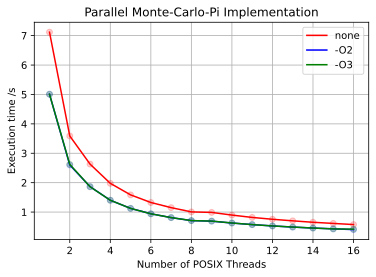

In [20]:
plt.plot(threads, parallel, "ro", alpha=0.2)
plt.plot(threads, parallel_o2, "bo", alpha=0.2)
plt.plot(threads, parallel_o3, "go", alpha=0.2)

plt.plot(threads, parallel, "r-", label="none")
plt.plot(threads, parallel_o2, "b-", label="-O2")
plt.plot(threads, parallel_o3, "g-", label="-O3")

plt.title("Parallel Monte-Carlo-Pi Implementation")
plt.xlabel("Number of POSIX Threads")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

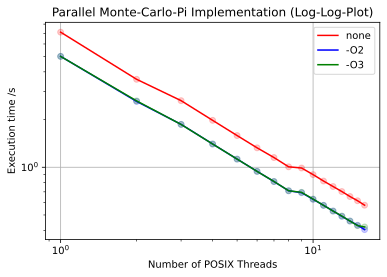

In [21]:
plt.plot(threads, parallel, "ro", alpha=0.2)
plt.plot(threads, parallel_o2, "bo", alpha=0.2)
plt.plot(threads, parallel_o3, "go", alpha=0.2)

plt.plot(threads, parallel, "r-", label="none")
plt.plot(threads, parallel_o2, "b-", label="-O2")
plt.plot(threads, parallel_o3, "g-", label="-O3")

plt.title("Parallel Monte-Carlo-Pi Implementation (Log-Log-Plot)")
plt.xlabel("Number of POSIX Threads")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

The runtime seems to correlate almost exactly linearly with the number of threads, but it shows a noticable "break" in both the linear and log-log plots between 8 and 9 threads. Since this corresponds to the point at which the number of threads is bigger than the number of "real" cores but smaller than the number of available threads in SMT mode, I assume that at some point, the implementation uses a part of the CPU that is not available twice per "real" CPU core.

#### Parallel Speedup

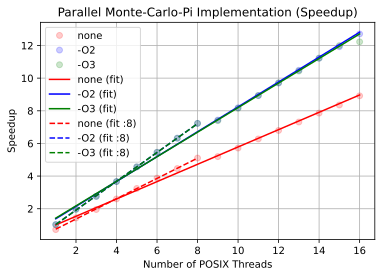

In [22]:
# get runtime of sequential algorithm at 500_000_000 iterations
fastest_sequential = np.array([sequential_o2[-2], sequential_o2[-2]]).min()

# calculate speedups
speedup = fastest_sequential / parallel
speedup_o2 = fastest_sequential / parallel_o2
speedup_o3 = fastest_sequential / parallel_o3

plt.plot(threads, speedup, "ro", alpha=0.2, label="none")
plt.plot(threads, speedup_o2, "bo", alpha=0.2, label="-O2")
plt.plot(threads, speedup_o3, "go", alpha=0.2, label="-O3")

# linear regression
coef = np.polyfit(threads, speedup, 1)
coef_o2 = np.polyfit(threads, speedup_o2, 1)
coef_o3 = np.polyfit(threads, speedup_o3, 1)

plt.plot(threads, np.poly1d(coef)(threads), "r-", label="none (fit)")
plt.plot(threads, np.poly1d(coef_o2)(threads), "b-", label="-O2 (fit)")
plt.plot(threads, np.poly1d(coef_o3)(threads), "g-", label="-O3 (fit)")

# linear regression for first 8 threads
coef_8 = np.polyfit(threads[:8], speedup[:8], 1)
coef_8_o2 = np.polyfit(threads[:8], speedup_o2[:8], 1)
coef_8_o3 = np.polyfit(threads[:8], speedup_o3[:8], 1)

plt.plot(threads[:8], np.poly1d(coef_8)(threads[:8]), "r--", label="none (fit :8)")
plt.plot(threads[:8], np.poly1d(coef_8_o2)(threads[:8]), "b--", label="-O2 (fit :8)")
plt.plot(threads[:8], np.poly1d(coef_8_o3)(threads[:8]), "g--", label="-O3 (fit :8)")

plt.title("Parallel Monte-Carlo-Pi Implementation (Speedup)")
plt.xlabel("Number of POSIX Threads")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

Especially with `-O2` compiler optimizations, the speedup achieved by allocating more threads is about linear. For 16 threads, the speedup compared to the sequential implementation running the same number of iterations, is over 13. However, when only looking at the speedup achieved for up to 8 threads, it is almost exactly linear with the number of allocated threads, and better than the speedup at thread counts higher than the number of "real" CPU cores.

In [23]:
data = np.array([threads, parallel, speedup, parallel_o2, speedup_o2, parallel_o3, speedup_o3]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "POSIX Threads",
        "none /s",
        "speedup",
        "-O2 /s",
        "speedup",
        "-O3 / s",
        "speedup",
    ]
)

HTML(df.to_html(index=False))

POSIX Threads,none /s,speedup,-O2 /s,speedup,-O3 / s,speedup
1.0,7.11775,0.722017,5.00932,1.025916,5.00675,1.026442
2.0,3.58870,1.432034,2.60178,1.975240,2.62279,1.959417
3.0,2.63183,1.952687,1.86527,2.755172,1.86312,2.758352
4.0,1.97727,2.599109,1.40251,3.664245,1.40186,3.665944
5.0,1.58554,3.241255,1.12590,4.564473,1.12621,4.563216
6.0,1.32644,3.874386,0.94252,5.452553,0.94191,5.456084
7.0,1.15179,4.461872,0.81260,6.324317,0.81340,6.318097
8.0,1.00676,5.104633,0.71085,7.229570,0.71114,7.226622
9.0,0.98945,5.193936,0.69135,7.433485,0.69481,7.396468
10.0,0.89889,5.717207,0.62789,8.184778,0.63005,8.156718


### LCC2 Performance measurements

→ `./montecarlo/sheet_02_3.job.sh`  
→ `./montecarlo/sheet_02_3.dat`

#### Sequential implementation

In [24]:
iterations = [
    100_000, 200_000, 500_000,
    1_000_000, 2_000_000, 5_000_000,
    10_000_000, 20_000_000, 50_000_000,
    100_000_000, 200_000_000, 500_000_000,
    1_000_000_000,
]

sequential = [
    0.00314,
    0.00622,
    0.01560,
    0.03103,
    0.06208,
    0.15520,
    0.31026,
    0.62019,
    1.55029,
    3.10071,
    6.20106,
    15.50324,
    31.00491,
]

sequential_o2 = [
    0.00220,
    0.00443,
    0.01113,
    0.02210,
    0.04395,
    0.11026,
    0.38385,
    0.43966,
    1.09935,
    2.18995,
    4.37971,
    10.94924,
    21.89804,
]

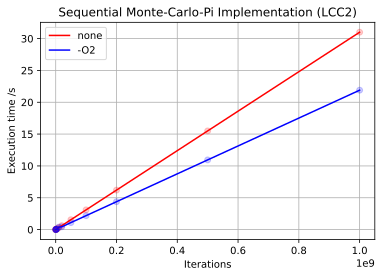

In [25]:
plt.plot(iterations, sequential, "ro", alpha=0.2)
plt.plot(iterations, sequential_o2, "bo", alpha=0.2)

plt.plot(iterations, sequential, "r-", label="none")
plt.plot(iterations, sequential_o2, "b-", label="-O2")

plt.title("Sequential Monte-Carlo-Pi Implementation (LCC2)")
plt.xlabel("Iterations")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

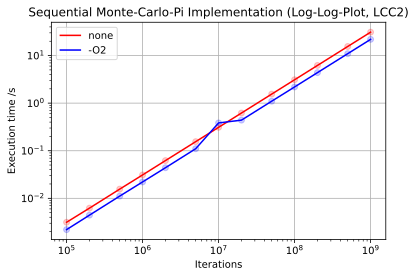

In [26]:
plt.plot(iterations, sequential, "ro", alpha=0.2)
plt.plot(iterations, sequential_o2, "bo", alpha=0.2)

plt.plot(iterations, sequential, "r-", label="none")
plt.plot(iterations, sequential_o2, "b-", label="-O2")

plt.title("Sequential Monte-Carlo-Pi Implementation (Log-Log-Plot, LCC2)")
plt.xlabel("Iterations")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

The measurements on LCC2 have a similar shape as the measurements from my local system, though measurements for the optimized program were not always stable (as seen in the log-log plot for the data point at \\( 10^7 \\) iterations).

In [27]:
data = np.array([iterations, sequential, sequential_o2]).T

df = pd.DataFrame(
    data,
    columns=[
        "iterations",
        "none /s",
        "-O2 /s",
    ]
)

HTML(df.to_html(index=False))

iterations,none /s,-O2 /s
1.000000e+05,0.00314,0.00220
2.000000e+05,0.00622,0.00443
5.000000e+05,0.01560,0.01113
1.000000e+06,0.03103,0.02210
2.000000e+06,0.06208,0.04395
5.000000e+06,0.15520,0.11026
1.000000e+07,0.31026,0.38385
2.000000e+07,0.62019,0.43966
5.000000e+07,1.55029,1.09935
1.000000e+08,3.10071,2.18995


#### Parallel implementation

In [28]:
THREADS = 8

threads = [*range(1, THREADS+1)]
iterations = 500_000_000

parallel = [
    15.54926,
    7.78325,
    5.18855,
    3.89335,
    3.13433,
    2.61028,
    2.22716,
    1.95637,
]

parallel_o2 = [
    10.95808,
    5.48412,
    3.65745,
    2.74321,
    2.20279,
    1.82950,
    1.57039,
    1.37391,
]

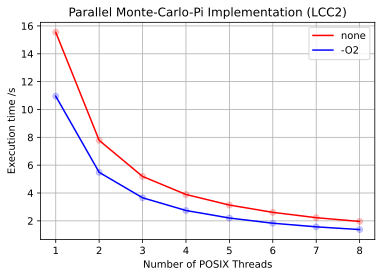

In [29]:
plt.plot(threads, parallel, "ro", alpha=0.2)
plt.plot(threads, parallel_o2, "bo", alpha=0.2)

plt.plot(threads, parallel, "r-", label="none")
plt.plot(threads, parallel_o2, "b-", label="-O2")

plt.title("Parallel Monte-Carlo-Pi Implementation (LCC2)")
plt.xlabel("Number of POSIX Threads")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

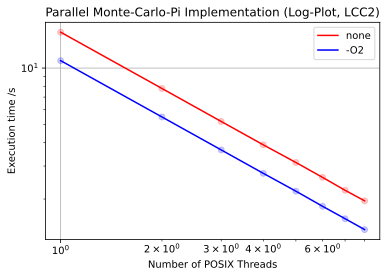

In [30]:
plt.plot(threads, parallel, "ro", alpha=0.2)
plt.plot(threads, parallel_o2, "bo", alpha=0.2)

plt.plot(threads, parallel, "r-", label="none")
plt.plot(threads, parallel_o2, "b-", label="-O2")

plt.title("Parallel Monte-Carlo-Pi Implementation (Log-Plot, LCC2)")
plt.xlabel("Number of POSIX Threads")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

#### Parallel Speedup

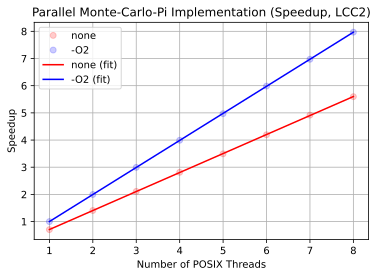

In [31]:
# get runtime of sequential algorithm at 500_000_000 iterations
fastest_sequential = np.array([sequential_o2[-2]])

# calculate speedups
speedup = fastest_sequential / parallel
speedup_o2 = fastest_sequential / parallel_o2

plt.plot(threads, speedup, "ro", alpha=0.2, label="none")
plt.plot(threads, speedup_o2, "bo", alpha=0.2, label="-O2")

# linear regression
coef = np.polyfit(threads, speedup, 1)
coef_o2 = np.polyfit(threads, speedup_o2, 1)

plt.plot(threads, np.poly1d(coef)(threads), "r-", label="none (fit)")
plt.plot(threads, np.poly1d(coef_o2)(threads), "b-", label="-O2 (fit)")

plt.title("Parallel Monte-Carlo-Pi Implementation (Speedup, LCC2)")
plt.xlabel("Number of POSIX Threads")
plt.ylabel("Speedup")

plt.legend()
plt.grid()
plt.show()

On LCC2, the speedup achieved by allocating more threads seems to be almost exactly linear, with the speedup for 8 threads being measured as 7.97.

In [32]:
data = np.array([threads, parallel, speedup, parallel_o2, speedup_o2]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "POSIX Threads",
        "none /s",
        "speedup",
        "-O2 /s",
        "speedup",
    ]
)

HTML(df.to_html(index=False))

POSIX Threads,none /s,speedup,-O2 /s,speedup
1.0,15.54926,0.704165,10.95808,0.999193
2.0,7.78325,1.406770,5.48412,1.996535
3.0,5.18855,2.110270,3.65745,2.993681
4.0,3.89335,2.812293,2.74321,3.991397
5.0,3.13433,3.493327,2.20279,4.970624
6.0,2.61028,4.194661,1.82950,5.984826
7.0,2.22716,4.916234,1.57039,6.972306
8.0,1.95637,5.596712,1.37391,7.969401


## Hardware + Software

- CPU: AMD Ryzen 7 1700X (8 Cores, 16 Threads)
- OS: Fedora Workstation 33
- Compiler: `gcc (GCC) 10.2.1 20201125 (Red Hat 10.2.1-9)`
- Report: Python 3.9.2, Jupyter Notebook 6.0.3, IPython 7.18.1, ipykernel 5.2.1, numpy 1.19.4, matplotlib 3.3.4, pandas 1.0.5